<a href="https://colab.research.google.com/github/mirklys/little-projects/blob/main/crop_yield_prediction/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Crop Yield Prediction

## Pre-setup

In [49]:
import os
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from functools import reduce
import zipfile
import re

# installing extra packages
try:
    from pyspark.sql import SparkSession
    from pyspark.sql import DataFrame
    from pyspark.sql.functions import col, regexp_replace, when, lit, sum, coalesce
    import rasterio
except:
    !pip install pyspark
    !pip install rasterio
    from pyspark.sql import SparkSession
    from pyspark.sql import DataFrame
    from pyspark.sql.functions import col, regexp_replace, when, lit, sum, coalesce
    import rasterio

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
# this is space for changing to gpu/tpu

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
PATH_MAIN = '/content/gdrive/MyDrive/Projects/Crop Yield Prediction'
os.chdir(PATH_MAIN)

Mounted at /content/gdrive


## Loading the data
The data folder contains files with different file extensions; many of the files must be extracted, some are .gz, some are .zip. 

In [ ]:
# Data folder contains: crop-yield, soil-properties, weather data
crop_yield_files = os.listdir('./data/crop-yield')
crop_yield_files = ['./data/crop-yield/' + f for f in crop_yield_files if not f.startswith('./data/crop-yield/')]


crop_yield_dfs = [spark.read.option("header", "true").csv(PATH_MAIN+f[1:]) for f in crop_yield_files]
# concatenate all DataFrames into a single DataFrame
crop_yield_df = reduce(lambda df1, df2: df1.unionAll(df2), crop_yield_dfs)

In [ ]:
# https://www.ncei.noaa.gov/pub/data/ghcn/daily/
weather_files = os.listdir('./data/weather')
weather_files = ['./data/weather/' + f for f in weather_files if not f.startswith('./data/weather/')]
weather_dfs = {}

for wf in weather_files[:1]:
    weather_dfs[wf[15:19]] = spark.read \
          .option("header", "false") \
          .option("inferSchema", "true") \
          .option("compression", "gzip") \
          .csv(wf)

weather_dfs = {year: df.withColumn('year', lit(year)) for year, df in weather_dfs.items()}
weather_df = reduce(lambda df1, df2: df1.unionAll(df2), weather_dfs.values())

In [ ]:
soil_properties_files = os.listdir('./data/soil-properties')
soil_properties_files = ['./data/soil-properties/' + f for f in soil_properties_files if not f.startswith('./data/soil-properties/')]
soil_properties_df = pd.DataFrame()
with zipfile.ZipFile(soil_properties_files[0], 'r') as zip_ref:
    zip_ref.extractall('./data/soil-properties/data/')
soil_properties_files_data = os.listdir('./data/soil-properties/data')
soil_properties_files_data = ['./data/soil-properties/data/' + f for f in soil_properties_files_data if not f.startswith('./data/soil-properties/data/')]
for spfd in soil_properties_files_data:
    if spfd.endswith('.zip'):
        with zipfile.ZipFile(spfd, 'r') as zip_ref:
            filename = os.path.splitext(os.path.basename(spfd))[0]
            zip_ref.extractall('./data/soil-properties/data/{}/'.format(filename))

In [ ]:
soil_properties_files_data = os.listdir('./data/soil-properties/data')
soil_properties_files_data = ['./data/soil-properties/data/' + f for f in soil_properties_files_data if not f.startswith('./data/soil-properties/data/')]

In [ ]:
soil_porosity_path = './data/soil-properties/data/por_gNATSGO/por_gNATSGO/por_gNATSGO_US.tif'
with rasterio.open(soil_porosity_path) as src:
    # Get the number of bands in the raster
    soil_porosity_data = src.read(1)
print('Number of bands in the raster:', soil_porosity_data)

## Analyzing Crop Yield

In [ ]:
crop_yield_df = crop_yield_df.drop("Week Ending","Ag District","Ag District Code", 'County',
                   'County ANSI', 'Zip Code', 'Region', 'WaterShed',
                   'Geo Level', 'watershed_code', 'Program', 'Period')
crop_yield_df = crop_yield_df.filter(~col("Data Item").rlike(r"\bSALES\b|\bOPERATIONS\b|\bPRODUCTION\b"))
crop_yield_df = crop_yield_df.withColumn("Value", regexp_replace("Value", "\(H\)|\(D\)", "null"))

In [ ]:
crop_yield_df.show()

+----+--------+----------+------------------+--------------------+--------------+--------------------+------+------+
|Year|   State|State ANSI|         Commodity|           Data Item|        Domain|     Domain Category| Value|CV (%)|
+----+--------+----------+------------------+--------------------+--------------+--------------------+------+------+
|2021| ALABAMA|        01| FIELD CROP TOTALS|FIELD CROP TOTALS...|ORGANIC STATUS|ORGANIC STATUS: (...| 1,270|  85.5|
|2021| ALABAMA|        01|               HAY|HAY, (EXCL ALFALF...|ORGANIC STATUS|ORGANIC STATUS: (...| 1,270|  85.5|
|2021| ALABAMA|        01|               HAY|HAY, ORGANIC - AC...|ORGANIC STATUS|ORGANIC STATUS: (...| 1,270|  85.5|
|2021| ARIZONA|        04|         CHICKPEAS|CHICKPEAS, ORGANI...|ORGANIC STATUS|ORGANIC STATUS: (...|  null|   (D)|
|2021| ARIZONA|        04|            COTTON|COTTON, ORGANIC -...|ORGANIC STATUS|ORGANIC STATUS: (...|  null|   (D)|
|2021| ARIZONA|        04| FIELD CROP TOTALS|FIELD CROP TOTALS..

In [ ]:
crop_total_df = crop_yield_df.filter(col('Commodity')=='FIELD CROP TOTALS')
crop_total_df = crop_total_df.drop('Commodity', 'Data Item', 'Domain',
                                   'Domain Category')

#crop_total_df = crop_total_df.withColumnRenamed("Value", "Total Harvested") \
#       .withColumn("Total Harvested", col("Total Harvested") * 4046.856422)
crop_total_df = crop_total_df.withColumnRenamed("Value", "total_harvested") \
                .withColumn("total_harvested",
                            when(col("total_harvested").rlike("\d+"), 
                                 regexp_replace(col("total_harvested"), ",", "") \
                                 .cast("integer") * 4046.86) \
                                 .otherwise(col("total_harvested")))
crop_total_df = crop_total_df.groupBy("Year", "State").agg(sum("total_harvested").alias("total_harvested"))

In [ ]:
crop_total_df.show()

+----+-------------+--------------------+
|Year|        State|     total_harvested|
+----+-------------+--------------------+
|2021|     ILLINOIS|      3.5803379792E8|
|2019|     DELAWARE|          1501385.06|
|2019|    WISCONSIN|      6.2511037048E8|
|2021|      INDIANA|1.7823585498000002E8|
|2021|NEW HAMPSHIRE|          9639620.52|
|2021|  CONNECTICUT|                null|
|2019|     MISSOURI|      1.3735852212E8|
|2019|     NEBRASKA|      4.6226877094E8|
|2019|     MICHIGAN|      3.4893645664E8|
|2021|      VERMONT|      1.9618772594E8|
|2021|   CALIFORNIA|      4.5017675326E8|
|2021|     COLORADO|      4.0018589168E8|
|2019|      WYOMING|      2.2564886674E8|
|2019|WEST VIRGINIA|  5649416.5600000005|
|2019|  MISSISSIPPI|       1.277998388E7|
|2019|        TEXAS| 6.463361511800001E8|
|2021|     MISSOURI|      1.8269954156E8|
|2019|     MARYLAND|       4.511034842E7|
|2021| RHODE ISLAND|            72843.48|
|2021|        TEXAS|      6.8275384432E8|
+----+-------------+--------------

In [22]:
crop_other_df = crop_yield_df.filter(col('Commodity')=='FIELD CROPS, OTHER')
crop_other_df = crop_other_df.drop('Commodity', 'Data Item', 'Domain',
                                   'Domain Category')

#crop_total_df = crop_total_df.withColumnRenamed("Value", "Total Harvested") \
#       .withColumn("Total Harvested", col("Total Harvested") * 4046.856422)
crop_other_df = crop_other_df.withColumnRenamed("Value", "total_harvested") \
                .withColumn("total_harvested",
                            when(col("total_harvested").rlike("\d+"), 
                                 regexp_replace(col("total_harvested"), ",", "") \
                                 .cast("integer") * 4046.86) \
                                 .otherwise(col("total_harvested")))
crop_other_df = crop_other_df.groupBy("Year", "State").agg(sum("total_harvested").alias("total_harvested"))
crop_other_df.show()

+----+--------------+------------------+
|Year|         State|   total_harvested|
+----+--------------+------------------+
|2021|      ILLINOIS|        1950586.52|
|2019|     WISCONSIN|          404686.0|
|2021|       INDIANA|              null|
|2019|      MISSOURI|              null|
|2019|      NEBRASKA|         372311.12|
|2019|      MICHIGAN|              null|
|2021|       VERMONT|2019383.1400000001|
|2021|    CALIFORNIA|3706923.7600000002|
|2021|      COLORADO|        1934399.08|
|2019|   MISSISSIPPI|              null|
|2021|      MISSOURI|              null|
|2021|         TEXAS|              null|
|2019|NORTH CAROLINA|         169968.12|
|2021|     WISCONSIN|         704153.64|
|2019|     MINNESOTA|         841746.88|
|2019|      KENTUCKY|445154.60000000003|
|2021|        NEVADA|          12140.58|
|2019|       FLORIDA|              null|
|2019|      COLORADO|        2938020.36|
|2019|       MONTANA|        8797873.64|
+----+--------------+------------------+
only showing top

```
from pyspark.sql.functions import coalesce, sum

# Merge the two data frames based on Year and State columns
merged_df = df1.join(df2, ['Year', 'State'], 'outer')

# Replace null values in total_harvested column of df1 with values from df2
merged_df = merged_df.withColumn('total_harvested', coalesce(merged_df['total_harvested'], merged_df['total_harvested']))

# Sum the values from both data frames and create a new column 'total_harvested_sum'
merged_df = merged_df.withColumn('total_harvested_sum', sum(merged_df['total_harvested'], merged_df['total_harvested']))

# Select the required columns
merged_df = merged_df.select('Year', 'State', 'total_harvested_sum')

# Show the final data frame
merged_df.show()
```




In [29]:
crop_total_df = crop_total_df.withColumnRenamed('total_harvested', 'total_harvested_total')
crop_other_df = crop_other_df.withColumnRenamed('total_harvested', 'total_harvested_other')

crops_df = crop_total_df.join(crop_other_df, ['Year', 'State'], 'outer')
crops_df = crops_df.fillna(0, subset=['total_harvested_total', 'total_harvested_other'])
crops_df = crops_df.withColumn('total_harvested_sum', crops_df['total_harvested_total']+crops_df['total_harvested_other'])
crops_df = crops_df.select('Year', 'State', 'total_harvested_sum')

crops_df.show()

+----+-------------+--------------------+
|Year|        State| total_harvested_sum|
+----+-------------+--------------------+
|2011|      ALABAMA|                 0.0|
|2011|      ARIZONA|1.2298407540000001E7|
|2011|     ARKANSAS|                 0.0|
|2011|   CALIFORNIA|      3.8612305318E8|
|2011|     COLORADO|      1.4217023866E8|
|2011|  CONNECTICUT|           218530.44|
|2011|     DELAWARE|                 0.0|
|2011|      FLORIDA|                 0.0|
|2011|      GEORGIA|  1845368.1600000001|
|2011|       HAWAII|                 0.0|
|2011|        IDAHO|      3.1830982016E8|
|2011|     ILLINOIS|         9.8541041E7|
|2011|      INDIANA|       3.477466798E7|
|2011|         IOWA|      2.5386357466E8|
|2011|       KANSAS|       1.156187902E8|
|2011|     KENTUCKY|          2946114.08|
|2011|    LOUISIANA|  3893079.3200000003|
|2011|        MAINE|        5.36613636E7|
|2011|     MARYLAND|2.3884567720000003E7|
|2011|MASSACHUSETTS|                 0.0|
+----+-------------+--------------

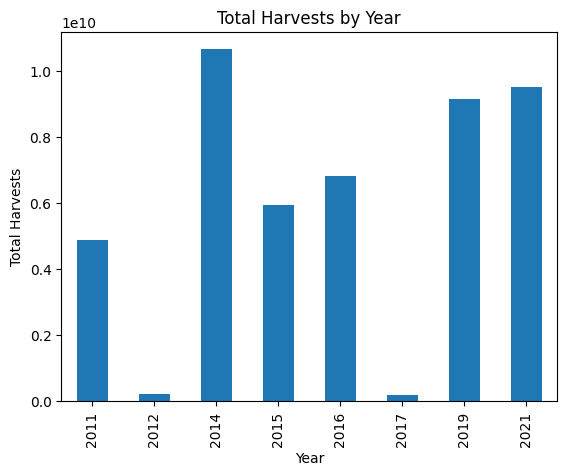

In [53]:
yearly_harvests = crops_df.toPandas().groupby('Year')['total_harvested_sum'].sum()

# Create a bar chart of yearly harvests
yearly_harvests.plot(kind='bar')
plt.title('Total Harvests by Year')
plt.xlabel('Year')
plt.ylabel('Total Harvests')
plt.show()

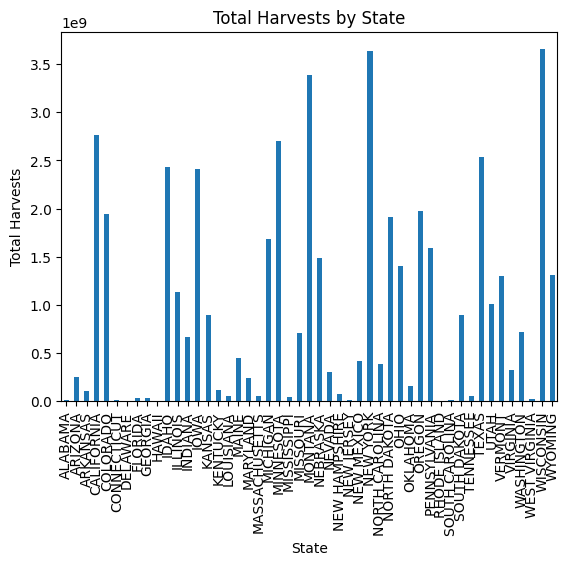

In [54]:
state_harvests = crops_df.toPandas().groupby('State')['total_harvested_sum'].sum()

# Create a bar chart of state harvests
state_harvests.plot(kind='bar')
plt.title('Total Harvests by State')
plt.xlabel('State')
plt.ylabel('Total Harvests')
plt.show()

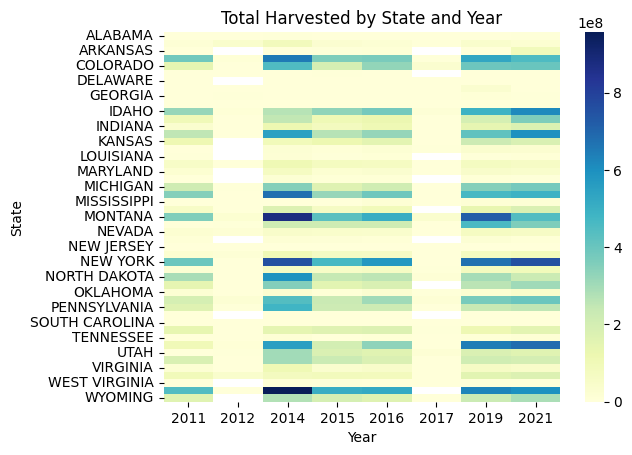

In [55]:
# Pivot the data to create a matrix of total_harvested_sum by state and year
pivoted_df = crops_df.toPandas().pivot(index='State', columns='Year', values='total_harvested_sum')

# Create a heatmap of total_harvested_sum by state and year
sns.heatmap(pivoted_df, cmap='YlGnBu')
plt.xlabel('Year')
plt.ylabel('State')
plt.title('Total Harvested by State and Year')
plt.show()

(38, 3)


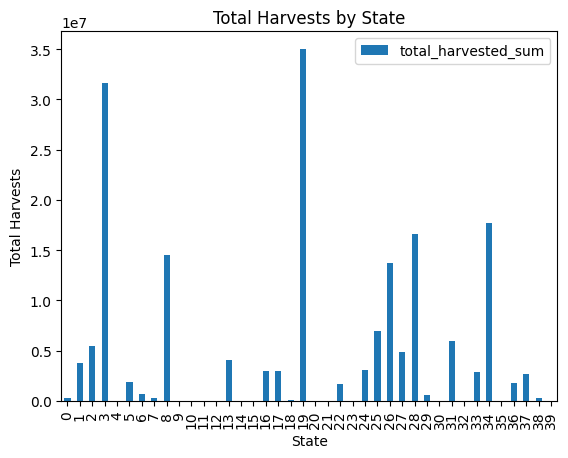

In [63]:
# why the crop yield is so low in 2012 and 2017, not a lot of nulls but just low values, check the weather or soil quality
crops_2012 = crops_df.filter(crops_df.Year == 2012)
crops_2017 = crops_df.filter(crops_df.Year == 2017)
print(crops_2012.toPandas().shape)
crops_2017.toPandas().plot(kind='bar')
plt.title('Total Harvests by State')
plt.xlabel('State')
plt.ylabel('Total Harvests')
plt.show()